# Trabajo de traducción de texto
### Autores: Laura Lucendo y Guillermo Valle

El trabajo propuesto consiste en la traducción de frases de inglés a español para los dos primeros casos (RNN y RNN Bidireccional) y en la traducción de frases de español a ingles en el caso de la LSTM. De esta manera se ha podido ver los dos casos y experimentar con ellos.


### 1. Import Required Libraries

In [95]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import numpy as np
from keras.models import Model
from keras.models import Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
from text import *

### 2. Read Data

En este primer paso, se indica el texto objeto de estudio. Este texto será el que se leerá y preprocesará a partir de las funciones definidas en el archivo _text.py_. Antes de ello, es necesario iniciar la clase __UTILS__ que recoge todas las funciones que se irán usando a medida que se avance en el notebook.

Por tanto, se inicia la clase __UTILS__ y, posteriormente se indica el texto a estudiar. Una vez indicado, se llama a la función _read_data_ que permite la obtención de un array de pares inglés/alemán o inglés/español según el archivo indicado. Para este proyecto, se usará el archivo inglés/español y, por tanto, los pares del array serán pares __inglés/español__.

In [55]:
utils = UTILS()
plots = PLOTS()

Instancia de la clase UTILS creada
Instancia de la clase PLOTS creada


In [56]:
filename= "spa-eng/spa.txt"
data_eng_spa=utils.read_data(filename=filename)
data_eng_spa=data_eng_spa[:,:2]
print(len(data_eng_spa))

122936


In [57]:
data_eng_spa[:50000,:]

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

Como se puede ver en las celdas anteriores, el array __data_eng_spa__ contiene 122936 entradas o pares de frases. Sin embargo, puesto a que entrenar tantas entradas puede llevar mucho tiempo, se usarán únicamente las primeras 50000 entradas con el fin de reducir el tiempo de entrenamiento. 

In [58]:
data_eng_spa = data_eng_spa[:50000,:]
print(len(data_eng_spa))

50000


### 3. Text Pre-Processing

En esta sección, se hace uso de la función _text_preprocessing_ con el fin de eliminar los signos de puntuación así como pasar a minúscula cada una de las frases que componen el array disponible. 

In [59]:
data_eng_spa_processed = utils.text_preprocessing(data_eng_spa)
data_eng_spa_processed

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

Como se puede ver en el output de la celda anterior, las frases ya no contienen puntos al final de las mismas y, además, se encuentran en minúscula.

Además, para alimentar los datos en un modelo Seq2Seq, es necesario convertir tanto las oraciones de entrada como las de salida en secuencias enteras de longitud fija. Antes de eso, se visualizan la longitud de las oraciones en la siguiente subsección _Text to Sequence Conversion_. Se capturan, por tanto, la longitud de todas las oraciones en dos listas separadas para inglés y español, respectivamente.

#### _Text to Sequence Conversion_



In [60]:
max_l1,max_l2,length_df = utils.get_length(data_eng_spa_processed)

In [61]:
print('Max length from the English text is: {}'.format(max_l1))
print('Max length from the Spanish text is: {}'.format(max_l2))
length_df.head()

Max length from the English text is: 8
Max length from the Spanish text is: 12


,eng,esp
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [62]:
length_df.eng.value_counts()

4    17029
5    14568
3     9855
6     5055
2     2958
7      464
1       61
8       10
Name: eng, dtype: int64

In [63]:
length_df.esp.value_counts()

4     15354
3     12148
5     10449
2      4784
6      4608
7      1494
1       698
8       363
9        69
10       27
11        3
12        3
Name: esp, dtype: int64

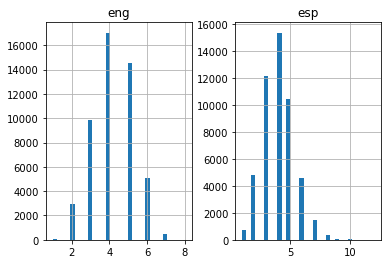

In [64]:
length_df.hist(bins = 30)
plt.show()

A partir de los resultados obtenidos en las celdas anteriores, se puede ver que la longitud máxima de las frases en __inglés__ es __8__, mientras que para las frases de __español__ la longitud máxima alcanzada es de __12__. Además, si se observa el histograma anterior, se puede concluir que para los dos casos las frases de una longitud de 4 palabras tienen una mayor frecuencia.

Una vez estudiadas las longitudes de ambos idiomas, se procede a asignar una longitud fija a los datos. Para ello, se vectorizan los datos de texto usando la clase _Tokenizer()_ de _Keras_. Convertirá las oraciones en secuencias de números enteros. Luego esas secuencias se rellenarán con ceros para hacer que todas las secuencias tengan la misma longitud.

La función _fit_on_texts_ que se usa en la función _tokenization_ definida en el archivo _text.py_ actualiza el vocabulario interno basado en una lista de textos. Este método crea el índice de vocabulario basado en la frecuencia de las palabras. Entonces, si le das algo como _"El gato se sentó en la alfombra"_, creará un diccionario como: wordindex[[el]] = 1; wordindex[[gato]] = 2 es palabra -> diccionario de índice, por lo que cada palabra obtiene un valor entero único. 0 está reservado para el __padding__. Por lo tanto, un número entero más bajo significa una palabra más frecuente (a menudo, las primeras son stop words porque aparecen muchas).

#### _Tokenization_


In [106]:
#Tokenizer aplicado a la columna eng (english)
eng_tokenized, eng_tokenizer = utils.tokenization(data_eng_spa_processed[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: {}'.format(eng_vocab_size))

English Vocabulary Size: 6942


In [110]:
print(eng_tokenizer.word_counts)

, 1), ('miserable', 1), ('cores', 1), ('landline', 1), ('ram', 1), ('fried', 1), ('bruises', 2), ('press', 3), ('intrude', 1), ('outsider', 1), ('throwing', 1), ('730', 2), ('motherinlaw', 1), ('nuisance', 2), ('skill', 1), ('ace', 3), ('clubs', 1), ('teenage', 1), ('tour', 1), ('consequences', 1), ('npr', 1), ('proposition', 1), ('carols', 1), ('secretary', 3), ('corrections', 1), ('crash', 4), ('cooperation', 1), ('1000', 1), ('partly', 1), ('warmer', 4), ('thai', 3), ('reckon', 1), ('strongly', 1), ('refrain', 2), ('unicycle', 3), ('sawing', 2), ('shredded', 3), ('document', 5), ('cheaply', 1), ('spent', 4), ('stretched', 1), ('thoroughly', 1), ('tend', 2), ('dissuade', 1), ('traffic', 6), ('youtube', 1), ('kobe', 1), ('suggestions', 1), ('stress', 1), ('crossing', 2), ('chores', 2), ('emotionally', 1), ('drained', 1), ('faithful', 1), ('coast', 2), ('difficulties', 1), ('average', 2), ('eighth', 2), ('repairing', 1), ('resigning', 1), ('since', 3), ('checked', 1), ('priorities', 1)

In [67]:
for sample_i, (sent, token_sent) in enumerate(zip(data_eng_spa_processed[:,0], eng_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

 in x
  Input:  he speaks english fluently
  Output: [8, 580, 328, 2894]
Sequence 49785 in x
  Input:  he speaks a little english
  Output: [8, 580, 5, 226, 328]
Sequence 49786 in x
  Input:  he started washing his car
  Output: [8, 386, 1280, 41, 81]
Sequence 49787 in x
  Input:  he stayed here for a while
  Output: [8, 891, 38, 35, 5, 808]
Sequence 49788 in x
  Input:  he still has much to learn
  Output: [8, 115, 45, 119, 7, 479]
Sequence 49789 in x
  Input:  he stood there for a while
  Output: [8, 864, 55, 35, 5, 808]
Sequence 49790 in x
  Input:  he stopped to talk to them
  Output: [8, 458, 7, 162, 7, 128]
Sequence 49791 in x
  Input:  he stopped to talk to them
  Output: [8, 458, 7, 162, 7, 128]
Sequence 49792 in x
  Input:  he studies chinese as well
  Output: [8, 1387, 1058, 118, 84]
Sequence 49793 in x
  Input:  he thanked me for the gift
  Output: [8, 2348, 10, 35, 6, 1148]
Sequence 49794 in x
  Input:  he thanked me for the gift
  Output: [8, 2348, 10, 35, 6, 1148]
Sequenc

In [68]:
#Tokenizer aplicado a la columna esp (español)
esp_tokenized, esp_tokenizer = utils.tokenization(data_eng_spa_processed[:, 1])
esp_vocab_size = len(esp_tokenizer.word_index) + 1
esp_length = 8
print('Spanish Vocabulary Size: {}'.format(esp_vocab_size))

Spanish Vocabulary Size: 14196


In [69]:
print(esp_tokenizer.word_counts)

al', 2), ('sillas', 6), ('rapidísimo', 1), ('búsqueda', 3), ('direcciones', 1), ('asistió', 2), ('vengó', 2), ('gracia', 4), ('apostó', 3), ('abrochó', 1), ('razonar', 1), ('aseguró', 1), ('agachaba', 1), ('sugeriste', 1), ('investigó', 1), ('destacado', 1), ('necesitó', 1), ('treintas', 1), ('sucesor', 1), ('aparenta', 1), ('ocupa', 2), ('esteroides', 2), ('alistó', 2), ('llenó', 1), ('espacios', 1), ('concedió', 1), ('desvío', 1), ('británico', 1), ('admirador', 2), ('temperamento', 2), ('rendido', 1), ('regañina', 1), ('acceso', 2), ('maritales', 1), ('cantado', 3), ('heredó', 1), ('exesposo', 1), ('yerno', 1), ('compulsivo', 3), ('convicto', 1), ('amistosa', 1), ('imprudente', 2), ('desconocido', 2), ('parpadeando', 1), ('masticando', 2), ('cortando', 1), ('lamentarlo', 1), ('recostado', 1), ('rival', 1), ('porche', 1), ('podando', 1), ('firmando', 1), ('cabro', 1), ('encenagado', 1), ('conversando', 1), ('patadas', 1), ('tacho', 1), ('decoroso', 1), ('necesitado', 2), ('movimiento

In [70]:
for sample_i, (sent, token_sent) in enumerate(zip(data_eng_spa_processed[:,1], esp_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

, 1516, 7, 126]
Sequence 49787 in x
  Input:  él se quedó aquí un rato
  Output: [11, 13, 515, 30, 8, 891]
Sequence 49788 in x
  Input:  él todavía tiene mucho que aprender
  Output: [11, 130, 37, 80, 9, 684]
Sequence 49789 in x
  Input:  se paró ahí por un rato
  Output: [13, 1149, 132, 19, 8, 891]
Sequence 49790 in x
  Input:  él se detuvo para hablarles
  Output: [11, 13, 2026, 51, 14152]
Sequence 49791 in x
  Input:  él se paró a hablar con ellos
  Output: [11, 13, 1149, 4, 118, 32, 53]
Sequence 49792 in x
  Input:  él también estudia chino
  Output: [11, 175, 1309, 1249]
Sequence 49793 in x
  Input:  me dio las gracias por el regalo
  Output: [10, 201, 26, 224, 19, 7, 704]
Sequence 49794 in x
  Input:  me agradeció por el regalo
  Output: [10, 4723, 19, 7, 704]
Sequence 49795 in x
  Input:  él me dio todos los detalles
  Output: [11, 10, 201, 58, 25, 1698]
Sequence 49796 in x
  Input:  él me dijo que me lavara la cara
  Output: [11, 10, 134, 9, 10, 14153, 6, 434]
Sequence 49797 in

#### _Padding_


In [71]:
def pad(x, length=None):
    if length is None:
        length = max([len(seq) for seq in x])
    return pad_sequences(x, maxlen=length, padding='post')

In [72]:
test_eng_pad = pad(eng_tokenized)

for sample_i, (token_sent, pad_sent) in enumerate(zip(eng_tokenized, test_eng_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))


75  136    5 4572]
  Output: [   8   15 1775  136    5 4572    0    0]
Sequence 49813 in x
  Input:  [   8   15 1775  136    5 4572]
  Output: [   8   15 1775  136    5 4572    0    0]
Sequence 49814 in x
  Input:  [  8  15 909  29   6 604]
  Output: [  8  15 909  29   6 604   0   0]
Sequence 49815 in x
  Input:  [   8   15 4189    5 2643]
  Output: [   8   15 4189    5 2643    0    0    0]
Sequence 49816 in x
  Input:  [   8   15  548   24 6922]
  Output: [   8   15  548   24 6922    0    0    0]
Sequence 49817 in x
  Input:  [   8   15 2849  367  106  989]
  Output: [   8   15 2849  367  106  989    0    0]
Sequence 49818 in x
  Input:  [   8   15  443   24   70 3744]
  Output: [   8   15  443   24   70 3744    0    0]
Sequence 49819 in x
  Input:  [   8   15 1024 1163]
  Output: [   8   15 1024 1163    0    0    0    0]
Sequence 49820 in x
  Input:  [   8   15 1024 1163]
  Output: [   8   15 1024 1163    0    0    0    0]
Sequence 49821 in x
  Input:  [  8  15 833 841  67]
  Output:

In [73]:
test_esp_pad = pad(esp_tokenized)

for sample_i, (token_sent, pad_sent) in enumerate(zip(esp_tokenized, test_esp_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

0]
Sequence 49846 in x
  Input:  [ 623    7 1221    6  246  920]
  Output: [ 623    7 1221    6  246  920    0    0    0    0    0    0]
Sequence 49847 in x
  Input:  [  11 1243   32   40 7432    9   86]
  Output: [  11 1243   32   40 7432    9   86    0    0    0    0    0]
Sequence 49848 in x
  Input:  [  11  396 1312  946   47  142]
  Output: [  11  396 1312  946   47  142    0    0    0    0    0    0]
Sequence 49849 in x
  Input:  [  11  396   15    7 6533]
  Output: [  11  396   15    7 6533    0    0    0    0    0    0    0]
Sequence 49850 in x
  Input:  [  11 7323    9 3532]
  Output: [  11 7323    9 3532    0    0    0    0    0    0    0    0]
Sequence 49851 in x
  Input:  [   11     3     8  2120 14167    32     6   976]
  Output: [   11     3     8  2120 14167    32     6   976     0     0     0     0]
Sequence 49852 in x
  Input:  [  11    3    8 2120 3663    5    6  976]
  Output: [  11    3    8 2120 3663    5    6  976    0    0    0    0]
Sequence 49853 in x
  Input: 

### 4. Model Building

La primera red que se ha entrenado ha sido una simple RNN, posteriormente se intentó realizar una bidireccional RNN y finalmente se ha realizado una LSTM con la que se han obtenido los mejores resultados.

### 4.1 Simple RNN

Un modelo RNN básico es una buena base para los datos de secuencia. En el modelo a continuación cse construye un RNN que traduzca del inglés al español.

In [74]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = utils.tokenization(x)
    preprocess_y, y_tk = utils.tokenization(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [75]:
preproc_english_sentences, preproc_spanish_sentences, english_tokenizer, spanish_tokenizer =\
    preprocess(data_eng_spa_processed[:,0], data_eng_spa_processed[:,1])

In [76]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_spanish_sequence_length = preproc_spanish_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
spanish_vocab_size = len(spanish_tokenizer.word_index)


In [77]:
print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max Spanish sentence length:", max_spanish_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("Spanish vocabulary size:", spanish_vocab_size)

Data Preprocessed
Max English sentence length: 8
Max Spanish sentence length: 12
English vocabulary size: 6941
Spanish vocabulary size: 14195


In [78]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param spanish_vocab_size: Number of unique Spanish words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(spanish_vocab_size + 1, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [79]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_spanish_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_spanish_sentences.shape[-2], 1))

In [80]:
model_file = './model_trained_3_may_simple.hdf5'
callback=[ModelCheckpoint(filepath=model_file, monitor='loss', verbose=1, save_best_only=True)]

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_spanish_sequence_length,
    english_vocab_size,
    spanish_vocab_size)


In [46]:
history=simple_rnn_model.fit(tmp_x, preproc_spanish_sentences, batch_size=1024, epochs=20, validation_split=0.2, callbacks=callback)

Epoch 1/20
40/40 [==============================] - 8147s 209s/step - loss: 1.8931 - accuracy: 0.7114 - val_loss: 2.7739 - val_accuracy: 0.6218

Epoch 00001: loss improved from 1.91816 to 1.89309, saving model to ./model_trained_3_may_simple.hdf5
Epoch 2/20
40/40 [==============================] - 185s 5s/step - loss: 1.8709 - accuracy: 0.7122 - val_loss: 2.7670 - val_accuracy: 0.6201

Epoch 00002: loss improved from 1.89309 to 1.87091, saving model to ./model_trained_3_may_simple.hdf5
Epoch 3/20
40/40 [==============================] - 188s 5s/step - loss: 1.8557 - accuracy: 0.7125 - val_loss: 2.7815 - val_accuracy: 0.6228

Epoch 00003: loss improved from 1.87091 to 1.85569, saving model to ./model_trained_3_may_simple.hdf5
Epoch 4/20
40/40 [==============================] - 191s 5s/step - loss: 1.8373 - accuracy: 0.7129 - val_loss: 2.7740 - val_accuracy: 0.6209

Epoch 00004: loss improved from 1.85569 to 1.83733, saving model to ./model_trained_3_may_simple.hdf5
Epoch 5/20
40/40 [===

In [47]:
plots=PLOTS()

Instancia de la clase PLOTS creada


<Figure size 1584x720 with 0 Axes>

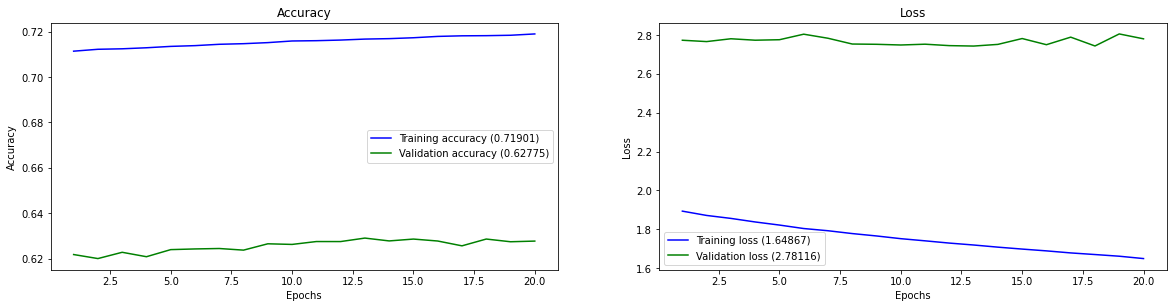

In [49]:
plots.plot_history(history)

In [ ]:
simple_rnn_model_scores = simple_rnn_model.evaluate(tmp_x, preproc_spanish_sentences, verbose=0)
print("Model Accuracy: %.2f%%" % (simple_rnn_model_scores[1]*100))

Una vez ha finalizado el entrenamiento del modelo, podemos observar las curvas de accuracy y loss. En ellas, se observa que los resultados no han sido buenos y esto se debe a que la red es muy sencilla para conseguir modelar bien los datos. 


### 4.2 Bidirectional RNN
A continuación, se prueba una RNN bidireccional. Una restricción de una RNN simple es que no puede ver la entrada futura, solo el pasado. Aquí es donde entran en juego las redes neuronales bidireccionales recurrentes que permiten tener en cuenta los datos a futuro. Las redes neuronales recurrentes bidireccionales (RNN) en realidad solo están uniendo dos RNN independientes. La secuencia de entrada se alimenta en orden de tiempo normal para una red y en orden de tiempo inverso para otra. Las salidas de las dos redes generalmente se concatenan en cada paso de tiempo, aunque hay otras opciones como por ejemplo la suma. 

Esta estructura permite que las redes tengan información tanto hacia atrás como hacia adelante sobre la secuencia en cada paso de tiempo.

In [36]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
    # Hiperparametros
    learning_rate = 1e-3
    
    inputs = Input(shape=input_shape[1:])
    x = Bidirectional(GRU(512, return_sequences=True))(inputs)
    x = TimeDistributed(Dense(spanish_vocab_size+1, activation='relu'))(x)
    predictions = Activation('softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [37]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_spanish_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_spanish_sentences.shape[-2], 1))

In [38]:
bd_rnn_model = bd_model(input_shape= tmp_x.shape,
    output_sequence_length=preproc_spanish_sentences.shape[1],
    english_vocab_size= english_vocab_size+1,
    spanish_vocab_size=spanish_vocab_size+1)
bd_rnn_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 12, 1024)          1582080   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 14196)         14550900  
_________________________________________________________________
activation_3 (Activation)    (None, 12, 14196)         0         
Total params: 16,132,980
Trainable params: 16,132,980
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_file = './bd_rnn.hdf5'
callback=[ModelCheckpoint(filepath=model_file, monitor='loss', verbose=1, save_best_only=True)]
history_bd = bd_rnn_model.fit(tmp_x, preproc_spanish_sentences, batch_size=1024, epochs=20, validation_split=0.2, callbacks=callback)


Epoch 1/20
40/40 [==============================] - 179s 4s/step - loss: 5.7926 - accuracy: 0.6081 - val_loss: 3.3230 - val_accuracy: 0.5949

Epoch 00001: loss improved from inf to 3.96862, saving model to ./bd_rnn.hdf5
Epoch 2/20
40/40 [==============================] - 196s 5s/step - loss: 2.5204 - accuracy: 0.6919 - val_loss: 3.2510 - val_accuracy: 0.6025

Epoch 00002: loss improved from 3.96862 to 2.50491, saving model to ./bd_rnn.hdf5
Epoch 3/20
40/40 [==============================] - 231s 6s/step - loss: 2.4726 - accuracy: 0.6973 - val_loss: 3.2239 - val_accuracy: 0.6061

Epoch 00003: loss improved from 2.50491 to 2.46641, saving model to ./bd_rnn.hdf5
Epoch 4/20
40/40 [==============================] - 203s 5s/step - loss: 2.4548 - accuracy: 0.6990 - val_loss: 3.2029 - val_accuracy: 0.6106

Epoch 00004: loss improved from 2.46641 to 2.44164, saving model to ./bd_rnn.hdf5
Epoch 5/20
40/40 [==============================] - 208s 5s/step - loss: 2.4236 - accuracy: 0.7021 - val_los

<Figure size 1584x720 with 0 Axes>

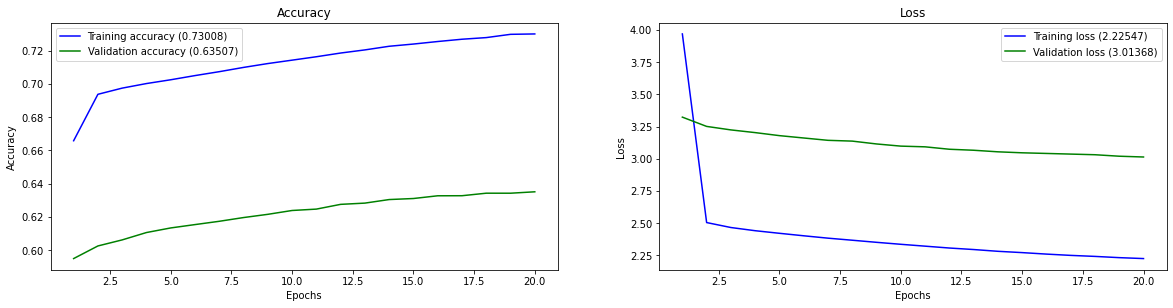

In [41]:
plots.plot_history(history_bd)

In [42]:
bd_rnn_model_scores = bd_rnn_model.evaluate(tmp_x, preproc_spanish_sentences, verbose=0)
print("Model Accuracy: %.2f%%" % (bd_rnn_model_scores[1]*100))

Model Accuracy: 71.21%


Vemos que para los datos de training la precisión obtenida es de un 71.21% mejor que la obtenida para el caso de la RNN simple donde los resultados no eran óptimos.

### 4.3 LSTM Model 

En esta última parte del proyecto, se desarrolla una LSTM a partir de la plantilla proporcionada en clase para ello. Al contrario que para el resto de modelos, las traducciones en este caso se harán de español a inglés.

Para comenzar con el modelo final de LSTM se realiza un particionado de los datos para entrenamiento y test y un preprocesado distinto a los anteriores.
Una vez se han definido los conjuntos de training y de test, se define también la arquitectura de un modelo Seq2Seq. Se usan tanto una capa Embedding como una capa LSTM como nuestro codificador y otra capa LSTM seguida de una capa densa como decodificador. 
Se utiliza, además, un optimizador de tipo RMSprop en este modelo, ya que suele ser una buena opción para redes neuronales recurrentes. En las siguientes celdas se lleva a cabo el entrenamiento así como el análisis de los resultados y se carga el modelo guardado con el filename especificado para realizar las predicciones sobre la muestra de test.

En esta sección se crea el modelo que se ha mencionado y se comienza con la preparación de los datos. Para ello, es necesario en primer lugar dividir el conjunto de datos en __training__ y __test__ con ayuda de la función _train_test_split_ como se muestra a continuación:

In [81]:
train, test = train_test_split(data_eng_spa_processed, test_size=0.2, random_state = 12)

Seguidamente, se llama a una función definida en el archivo _text.py_: _encode_sequences_ para preparar las secuencias. También realizará el relleno de secuencia hasta una longitud máxima de oración como se mencionó anteriormente. 

Se codificarán oraciones en __español__ como __secuencias de entrada__ y oraciones en __inglés__ como __secuencias objetivo__. Se realizará tanto para conjuntos de datos de prueba como para conjuntos de test.


In [82]:
# prepare training data
trainX = utils.encode_sequences(esp_tokenizer, esp_length, train[:, 1])
trainY = utils.encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [83]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [84]:
# prepare validation data
testX = utils.encode_sequences(esp_tokenizer, esp_length, test[:, 1])
testY = utils.encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [85]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


### 4.3.1 Arquitectura del modelo y entrenamiento

In [86]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

In [87]:
print('La longitud del vocabulario inglés es: {}'.format(eng_vocab_size))
print('La longitud del vocabulario español es: {}'.format(esp_vocab_size))
print('La longitud máxima definida para el vocavularion inglés es: {}'.format(eng_length))
print('La longitud máxima definida para el vocavularion español es: {}'.format(esp_length))

La longitud del vocabulario inglés es: 6942
La longitud del vocabulario español es: 14196
La longitud máxima definida para el vocavularion inglés es: 8
La longitud máxima definida para el vocavularion español es: 8


In [88]:
model = build_model(esp_vocab_size, eng_vocab_size, esp_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Se ha utilizado __ 'sparse_categorical_crossentropy' __ como la función de pérdida porque permite usar la secuencia de destino tal como está en lugar de usar un formato como _one-hot-encoding_. El _one-hot-encoding_ de las secuencias de destino con un vocabulario tan grande podría consumir toda la memoria de nuestro sistema.

Por tanto, una vez se ha definido la arquitectura así como el optimizador y la función de pérdida, se procede a entrenar el modelo. Se entrena durante 30 épocas y con un _batch_size_ de 512. También se usa __ModelCheckpoint() __ para guardar el mejor modelo con la menor pérdida de validación. 

In [89]:
best_model_file = './model_trained_3_may.hdf5'
callback=[ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]


#checkpoint = [ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min'), ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]


history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=40, batch_size=512, 
          validation_split = 0.2, verbose=0,callbacks=callback)


Epoch 00001: loss improved from inf to 3.92986, saving model to ./model_trained_3_may.hdf5

Epoch 00002: loss improved from 3.92986 to 3.24383, saving model to ./model_trained_3_may.hdf5

Epoch 00003: loss improved from 3.24383 to 3.08048, saving model to ./model_trained_3_may.hdf5

Epoch 00004: loss improved from 3.08048 to 2.94956, saving model to ./model_trained_3_may.hdf5

Epoch 00005: loss improved from 2.94956 to 2.80954, saving model to ./model_trained_3_may.hdf5

Epoch 00006: loss improved from 2.80954 to 2.64886, saving model to ./model_trained_3_may.hdf5

Epoch 00007: loss improved from 2.64886 to 2.49802, saving model to ./model_trained_3_may.hdf5

Epoch 00008: loss improved from 2.49802 to 2.35861, saving model to ./model_trained_3_may.hdf5

Epoch 00009: loss improved from 2.35861 to 2.22556, saving model to ./model_trained_3_may.hdf5

Epoch 00010: loss improved from 2.22556 to 2.10116, saving model to ./model_trained_3_may.hdf5

Epoch 00011: loss improved from 2.10116 to 

### 4.3.2 Análisis de resultados

A continuación, se crea la instancia de la clase PLOTS y se compara la pérdida del entrenamiento con la pérdida de la validación. Para ello, se llama a la función _plot_history_ definida en el archivo _text.py_ que mostrará en pantalla los gráficos de pérdida y precisión.

In [90]:
plots= PLOTS()

Instancia de la clase PLOTS creada


<Figure size 1584x720 with 0 Axes>

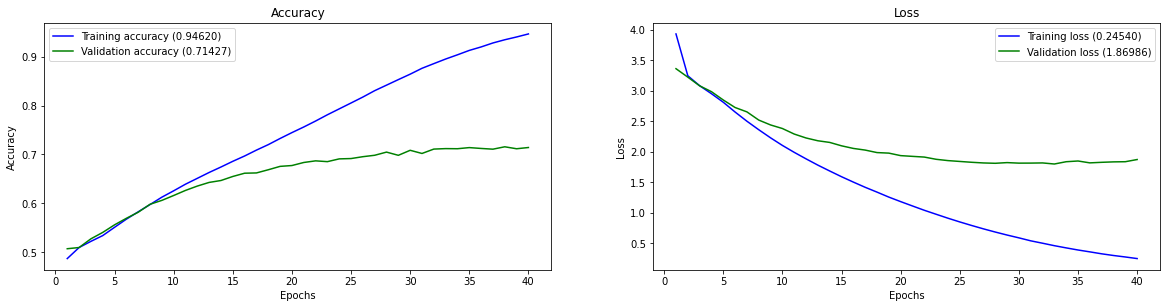

In [91]:
plots.plot_history(history)

In [92]:
print("Brief summary of final accuracies: \n ")
score = model.evaluate(trainX, trainY, verbose=0) 
print ("Model train data score : {} %".format(round(score[1]*100)))

score = model.evaluate(testX, testY, verbose=0) 
print ("Model test data score : {} % ".format(round(score[1]*100)))



Brief summary of final accuracies: 
 
Model train data score : 91 %
Model test data score : 72 % 


Se podría decir, a partir de los resultados obtenidos en la celda anterior, que existe cierto __overfitting__ en el modelo pues la precisión obtenida para las muestras de entrenamiento es considerablemente mayor que la obtenida para el conjunto de test. Sin embargo, la precisión obtenida para el conjunto de test no es mala pero se podría mejorar aplicando algunas de las siguientes opciones: 

- Dropout para reducir el sobreentrenamiento. 
- Aumentar el número de épocas en todos los modelos para así poder tener una visión clara del rendimiento d elos mismos. Puede ser que el error de validación siga decreciendo a medida que se aumenta el número de épocas hasta un valor determinado.
- Se podría además tratar de ver cómo cambiar la capa del modelo bidireccional de una capa GRU a una capa LSTM pues las LSTM permiten recordar secuencias mayores que las GRU y esto puede hacer que el modelo bidireccional mejore.

### 4.3.3 Make Predictions with saved LSTM model

A continuación, se carga el modelo entrenado anteriormente y se hacen predicciones. Para ello, hay que convertir la secuencia predicha en palabras usando la función _get_word_ definida en la clase __UTILS__ del archivo _text.py_. Esta función se muestra además en las celdas a continuación.

In [103]:
model = load_model('model_trained_3_may.hdf5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [112]:
def get_word(n, tokenizer):
        """
        Función para convertir las secuencias predichas en palabras a partir de un tokenizer y un índice.
        
        Args: 
            n = número que debe matchear con el índice
            tokenizer = se especifica el tokenizer a usar.

        """

        for word, index in tokenizer.word_index.items():
            if index == n:
                return word
        return None

In [113]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

A partir de las predicciones anteriores, como bien se explica al comienzo de esta sección, se llama a la función _get_word_ con el fin de convertir las secuencias a palabras.

In [114]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

Se crea un dataframe en el que se recogen las frases verdaderas en la primera columna y las predicciones hechas por nuestro modelo en la segunda columna.

In [115]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may it
3,thats private,thats is nonsense
4,tom leaped from his seat,tom wears at his
5,have you ever sold a car,did you out in a car
6,how many kids do you have,how many kids do you have
7,i will not let you do it,i wont let you do
8,isnt it beautiful,isnt it beautiful
9,my parrot died yesterday,my father was


A continuación se pueden ver distintas partes del dataframe creado, donde se pueden observar el valor actual y el predicho por el modelo. Se puede ver que, en general, las frases predichas por el modelo no difieren en gran medida de las frases reales y, por tanto, se puede entender en muchos casos el significado de las frases predichas.

In [116]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom know help mary
9986,tom can be clumsy,tom can be useful
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it was
9989,shes also a beauty,its is an
9990,i love your daughter,i want your opinion
9991,he teaches english,he speaks in cry
9992,i overslept,i fell asleep
9993,he is as poor as can be,he is as poor
9994,wheres my shirt,wheres my


In [117]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,does tom know help mary
9986,tom can be clumsy,tom can be useful
9987,do you want to try it,do you want to try it
9988,do you know who he was,do you know who it was
9989,shes also a beauty,its is an
9990,i love your daughter,i want your opinion
9991,he teaches english,he speaks in cry
9992,i overslept,i fell asleep
9993,he is as poor as can be,he is as poor
9994,wheres my shirt,wheres my


In [118]:
pred_df.sample(15)

,actual,predicted
2011,what have you heard tom,what did you learn from
7506,i did everything for you,ive all you
5843,did you come here alone,have you come go here
528,i dont really know you,i dont even know you
9428,thank you for the help,thanks for the help
6606,here is my bicycle,here is here
3176,everybody but tom smiled,everybody was remembered tom
3107,tom said it was a joke,tom said he was a
7868,let me see it,let me see
3194,can you repair my shoes,may i open my eyes


### 4.4 Conclusiones
Como se ha podido ver en los resultados de los modelos, la LSTM ha sido capaz de ofrecer mejores resultados que la simple RNN. Aunque nuestra red de LSTM tiene sobreentrenamiento, ha sido capaz de tener un 72% en test.

Todas las RNNs tienen ciclos de retroalimentación en la capa recurrente. Esto les permite mantener información en _memoria_ a lo largo del tiempo. Sin embargo, puede ser difícil capacitar a las RNNs simples para resolver problemas que requieren aprender dependencias temporales a largo plazo. Esto se debe a que el gradiente de la función de pérdida decae exponencialmente con el tiempo (vanishing gradient problem). 

Las redes LSTM son un tipo de RNN que usa unidades especiales además de las unidades estándar. Las unidades LSTM incluyen una _celda de memoria_ que puede mantener información en la memoria durante largos períodos de tiempo. Un conjunto de puertas se usa para controlar cuándo la información ingresa en la memoria, cuándo se emite y cuándo se olvida. 

Esta arquitectura les permite conocer las dependencias a más largo plazo. Los GRU son similares a los LSTM, pero utilizan una estructura simplificada. También usan un conjunto de puertas para controlar el flujo de información, pero no usan celdas de memoria separadas y usan menos puertas.

El modelo bidireccional hace uso de las GRU y es por ello por lo que se esperaban resultados como los obtenidos. A partir de lo explicado anteriormente, tiene sentido que el modelo que tiene un mejor rendimiento sea el LSTM pues recoge una mayor cantidad de información en su memoria lo que le permite mejorar su precisión. Por el contrario, las GRU tienen una arquitectura más simplificada lo que supone un rendimiento un poco peor que el de las LSTM pero bastante mejor que el que se obtiene a partir de una red recurrente simple.